In [4]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import scipy.io
from sklearn.neighbors import NearestCentroid
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

### load data

In [5]:
mat = scipy.io.loadmat('../datasets/fashion.mat')

In [6]:
X_train = mat['Xtr']
y_train = mat['ytr']
X_test = mat['Xtst']
y_test = mat['ytst']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 784), (60000, 1), (10000, 784), (10000, 1))

### 1. nearest centroid classification with original images (no pca yet)

In [7]:
clf = NearestCentroid()
clf.fit(X_train, y_train.ravel())

y_pred = clf.predict(X_test)

print('error = ', 1- accuracy_score(y_test,y_pred))

error =  0.32320000000000004


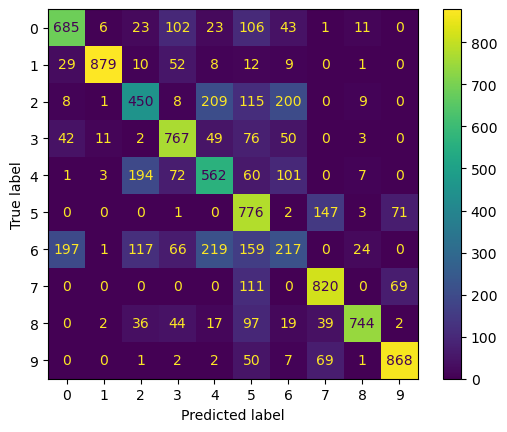

In [8]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=clf.classes_)
disp.plot();

### 2. Apply PCA to reduce dimension first and then perform k nearest neighbor (kNN) classification (Euclidean distance, no weighting).

For this data set, 50 dimensions might no longer be the best choice. So there are two parameters to be tuned: m (number of pca dimensions) and k (number of nearest neighbors).

A large scale grid search over (m,k) could find the optimal pair in terms of test error (or validation error). However, it will be slow.

Here, let us fix m to a small number of values such as 50, 100, 150 (feel free to change these numbers). For each value of m, perform PCA to project both the training and test data into the same m dimensional space. Afterwards, perform kNN classification on the m-dimensional PCA reduced data, for k = 1, 2, ..., 12. Plot the test errors against k, one curve for each fixed value of m.

What is a good choice of the pair (m,k), in terms of test error?

In [6]:
m_values = [50, 100, 150, 200]
k_values = range(1, 13)

errors = {}

for m in m_values:
    pca = PCA(n_components=m)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    for k in k_values:
        clf = KNeighborsClassifier(n_neighbors=k)
        clf.fit(X_train_pca, y_train.ravel())
        y_pred = clf.predict(X_test_pca)
        errors[(m, k)] = 1 - accuracy_score(y_test, y_pred)
        print('m =', m, 'k =', k, 'error =', errors[(m, k)])

best_params = min(errors, key=errors.get)
print('best_params =', best_params)
print('error =', errors[best_params])

m = 50 k = 1 error = 0.15790000000000004
m = 50 k = 2 error = 0.1582
m = 50 k = 3 error = 0.1481
m = 50 k = 4 error = 0.14239999999999997
m = 50 k = 5 error = 0.14349999999999996
m = 50 k = 6 error = 0.14139999999999997
m = 50 k = 7 error = 0.14170000000000005
m = 50 k = 8 error = 0.14180000000000004
m = 50 k = 9 error = 0.1431
m = 50 k = 10 error = 0.14159999999999995
m = 50 k = 11 error = 0.1421
m = 50 k = 12 error = 0.14339999999999997
m = 100 k = 1 error = 0.15149999999999997
m = 100 k = 2 error = 0.15039999999999998
m = 100 k = 3 error = 0.13959999999999995
m = 100 k = 4 error = 0.13759999999999994
m = 100 k = 5 error = 0.13729999999999998
m = 100 k = 6 error = 0.13580000000000003
m = 100 k = 7 error = 0.13980000000000004
m = 100 k = 8 error = 0.13780000000000003
m = 100 k = 9 error = 0.139
m = 100 k = 10 error = 0.13880000000000003
m = 100 k = 11 error = 0.14129999999999998
m = 100 k = 12 error = 0.1401
m = 150 k = 1 error = 0.14739999999999998
m = 150 k = 2 error = 0.14800000000

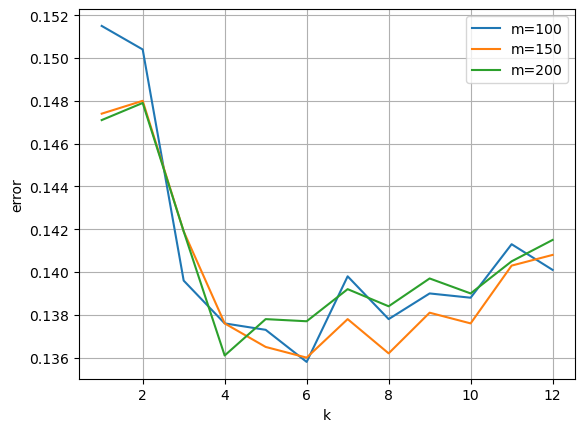

In [7]:
# Plot all lines for each m, k pair

for m in m_values[1:]:
    plt.plot(k_values, [errors[(m, k)] for k in k_values], label=f'm={m}')
plt.legend()
plt.xlabel('k')
plt.ylabel('error')
plt.grid()
plt.show()

In [8]:
best_m = best_params[0]
best_m

100

### 3 For the best value of m found above, perform unweighted kNN classification with city block distance ($\ell_1$) for k = 1,2,..., 12. 

Plot the test errors against k. How does it compare with unweighted kNN + Euclidean metric ($\ell_2$)?

In [9]:
k_values = range(1, 13)

manhatten_errors = []
euclidean_errors = []

pca = PCA(n_components=best_m)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
for k in k_values:
    clf = KNeighborsClassifier(n_neighbors=k, metric='manhattan')
    clf.fit(X_train_pca, y_train.ravel())
    y_pred = clf.predict(X_test_pca)
    manhatten_errors.append(1 - accuracy_score(y_test, y_pred))
    print('Manhattan: m =', best_m, 'k =', k, 'error =', manhatten_errors[k-1])

    clf = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    clf.fit(X_train_pca, y_train.ravel())
    y_pred = clf.predict(X_test_pca)
    euclidean_errors.append(1 - accuracy_score(y_test, y_pred))
    print('Euclidean: m =', best_m, 'k =', k, 'error =', euclidean_errors[k-1])

Manhattan: m = 100 k = 1 error = 0.14649999999999996
Euclidean: m = 100 k = 1 error = 0.15149999999999997
Manhattan: m = 100 k = 2 error = 0.14680000000000004
Euclidean: m = 100 k = 2 error = 0.15039999999999998
Manhattan: m = 100 k = 3 error = 0.136
Euclidean: m = 100 k = 3 error = 0.13959999999999995
Manhattan: m = 100 k = 4 error = 0.13429999999999997
Euclidean: m = 100 k = 4 error = 0.13759999999999994
Manhattan: m = 100 k = 5 error = 0.13470000000000004
Euclidean: m = 100 k = 5 error = 0.13729999999999998
Manhattan: m = 100 k = 6 error = 0.13249999999999995
Euclidean: m = 100 k = 6 error = 0.13580000000000003
Manhattan: m = 100 k = 7 error = 0.13360000000000005
Euclidean: m = 100 k = 7 error = 0.13980000000000004
Manhattan: m = 100 k = 8 error = 0.13460000000000005
Euclidean: m = 100 k = 8 error = 0.13780000000000003
Manhattan: m = 100 k = 9 error = 0.13590000000000002
Euclidean: m = 100 k = 9 error = 0.139
Manhattan: m = 100 k = 10 error = 0.1361
Euclidean: m = 100 k = 10 error =

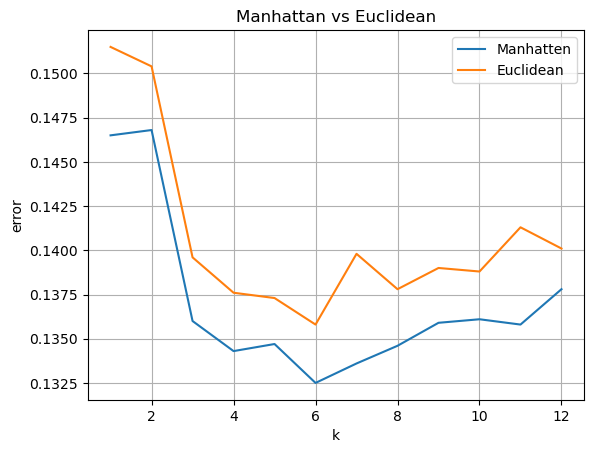

In [10]:
plt.plot(k_values, manhatten_errors, label='Manhatten')
plt.plot(k_values, euclidean_errors, label='Euclidean')
plt.legend()
plt.xlabel('k')
plt.ylabel('error')
plt.grid()
plt.title('Manhattan vs Euclidean')
plt.show()

### 4. For the best value of m found above, perform kNN classification + Euclidean metric, with inverse distance weights, for k = 1,2,...,12. 

Plot the test errors against k.  How does the weighted kNN compare with the unweighted kNN (both with Euclidean metric)

In [11]:
inverse_errors = []

for k in k_values:
    clf = KNeighborsClassifier(n_neighbors=k, metric='euclidean', weights='distance')
    clf.fit(X_train_pca, y_train.ravel())
    y_pred = clf.predict(X_test_pca)
    inverse_errors.append(1 - accuracy_score(y_test, y_pred))
    print('Inverse: m =', best_m, 'k =', k, 'error =', inverse_errors[k-1])

Inverse: m = 100 k = 1 error = 0.15149999999999997
Inverse: m = 100 k = 2 error = 0.15149999999999997
Inverse: m = 100 k = 3 error = 0.13890000000000002
Inverse: m = 100 k = 4 error = 0.1361
Inverse: m = 100 k = 5 error = 0.1351
Inverse: m = 100 k = 6 error = 0.136
Inverse: m = 100 k = 7 error = 0.13839999999999997
Inverse: m = 100 k = 8 error = 0.13560000000000005
Inverse: m = 100 k = 9 error = 0.1372
Inverse: m = 100 k = 10 error = 0.135
Inverse: m = 100 k = 11 error = 0.13729999999999998
Inverse: m = 100 k = 12 error = 0.13639999999999997


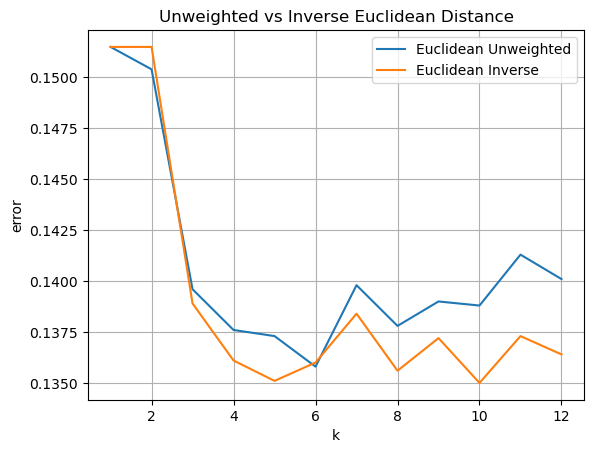

In [12]:
plt.plot(k_values, euclidean_errors, label='Euclidean Unweighted')
plt.plot(k_values, inverse_errors, label='Euclidean Inverse')
plt.legend()
plt.xlabel('k')
plt.ylabel('error')
plt.grid()
plt.title('Unweighted vs Inverse Euclidean Distance')
plt.show()

### 5. Implment the nearest local centroid classifier (with Euclidean distance) and apply it to the m-dimensional PCA reduced data for various values of k. 

Plot the test errors against k.

In [9]:
h=0.2
cmap_light = plt.cm.Paired
cmap_bold = plt.cm.Paired

In [11]:
best_m = 100

In [12]:
k_values = range(1, 13)

errors = []

pca = PCA(n_components=best_m)  # Reduce to 2 dimensions for visualization
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

k = 1, error = 32.32%
k = 2, error = 32.32%
k = 3, error = 32.32%
k = 4, error = 32.32%
k = 5, error = 32.32%
k = 6, error = 32.32%
k = 7, error = 32.32%
k = 8, error = 32.32%
k = 9, error = 32.32%
k = 10, error = 32.32%
k = 11, error = 32.32%
k = 12, error = 32.32%


In [26]:
for k in k_values:
    clf = KNeighborsClassifier(n_neighbors=k, metric='euclidean', weights='distance')
    clf.fit(X_train_pca, y_train.ravel())
    
    # find the centroid of each class
    centroids = np.zeros((len(clf.classes_), best_m))
    for i in clf.classes_:
        centroids[i] = np.mean(X_train_pca[y_train.ravel() == i], axis=0)

    # For each test points, find the closest centroid
    y_pred = np.zeros(y_test.shape)
    for i in range(X_test_pca.shape[0]):
        distances = np.linalg.norm(centroids - X_test_pca[i], axis=1)
        y_pred[i] = np.argmin(distances)

    error = 1 - accuracy_score(y_test, y_pred)
    errors.append(error)
    print(f'k = {k}, error = {error*100:.2f}%')


k = 1, error = 32.32%
k = 2, error = 32.32%
k = 3, error = 32.32%
k = 4, error = 32.32%
k = 5, error = 32.32%
k = 6, error = 32.32%
k = 7, error = 32.32%
k = 8, error = 32.32%
k = 9, error = 32.32%
k = 10, error = 32.32%
k = 11, error = 32.32%
k = 12, error = 32.32%


In [35]:
class_centroids

{0: array([ 6.85822396e+02, -6.10317773e+02, -4.80127109e+01,  2.68951098e+02,
         8.51035578e+01,  6.64172946e+02, -7.83623109e+01, -2.58629364e+01,
         1.11899914e+01, -2.75101026e+01, -4.78820601e+01,  2.83565420e+01,
        -5.94775706e+01,  1.23942654e+01,  4.23953690e+01,  2.51203908e+01,
         4.37049231e+01, -1.47931514e+01,  1.87323667e+01, -3.94916018e+01,
         9.56204497e+00,  4.08935700e+00,  3.18170358e+01,  1.65012985e+01,
         5.73711793e+00,  2.22083456e+00,  1.79074367e+01, -3.92838409e+00,
        -1.91086622e+01, -1.34387303e+01, -1.27680849e+01, -6.34689434e+00,
         4.85813495e+00, -2.66868559e+00, -7.38835781e+00,  7.91669085e+00,
         1.43272916e+00,  6.08071482e-01, -3.32532184e+00,  2.96370866e+00,
         4.77773625e+00, -1.22463369e+01,  8.41969397e+00,  2.52049294e-01,
        -1.14037986e+00,  2.27659730e+00, -3.33556992e-01,  8.45923323e+00,
         2.95742084e+00, -2.58251898e+00, -2.40929478e+00, -1.90719849e+00,
        -

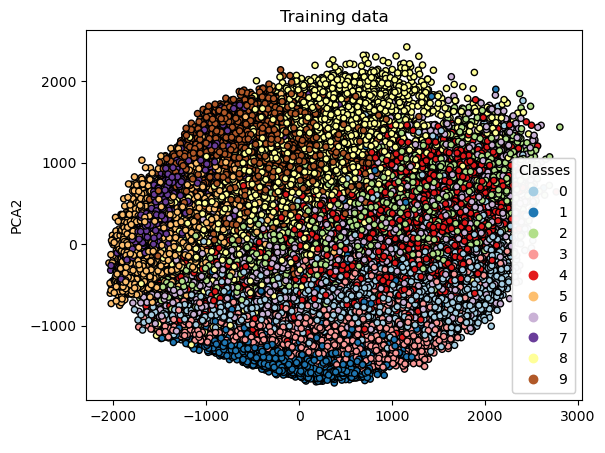

In [23]:

# Create a scatter plot with labels for the legend
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train.ravel(), cmap=cmap_bold, edgecolor='k', s=20)

# Create a custom legend
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend1)

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Training data')
plt.show()

In [ ]:

# # Plot the decision boundary. For that, we will assign a color to each
# # point in the mesh [x_min, x_max]x[y_min, y_max].
# x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
# y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
# xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
#                         np.arange(y_min, y_max, h))
# Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# # Put the result into a color plot
# Z = Z.reshape(xx.shape)
# plt.figure()
# plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# # Plot also the training points
# plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.Paired)
# plt.xlim(xx.min(), xx.max())
# plt.ylim(yy.min(), yy.max())
# plt.xlabel('1st eigenvector')
# plt.ylabel('2nd eigenvector')
# plt.title('KNN decision boundary (k = 5)')
# plt.show()


    

ValueError: x and y must have same first dimension, but have shapes (12,) and (0,)

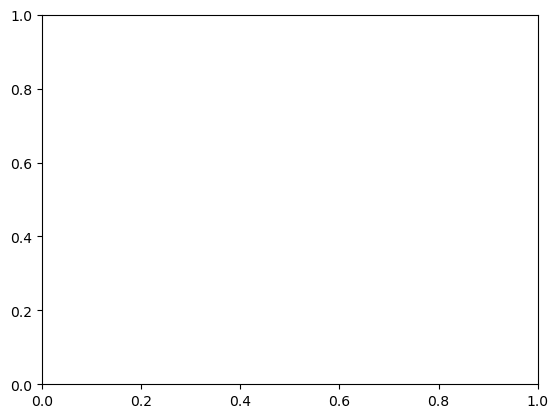

In [14]:
plt.plot(k_values, errors)
plt.xlabel('k')
plt.ylabel('error')
plt.grid()
plt.title('Nearest Local Centroid')
plt.show()